In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             recall_score, classification_report, 
                             confusion_matrix, roc_curve, precision_score)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import shap
import dice_ml

c:\Users\User\anaconda3\envs\tf210\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('whitegrid')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

In [3]:
# 1. Data Loading & Preprocessing
df = pd.read_csv("german_credit_data.csv") 

df = df.iloc[:, 1:] 

df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})

print(f"Data shape: {df.shape}")
print("Column names:", df.columns.tolist())

Data shape: (1000, 10)
Column names: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']


Starting EDA Analysis


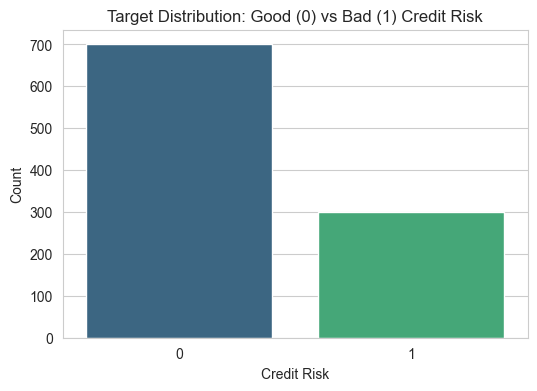

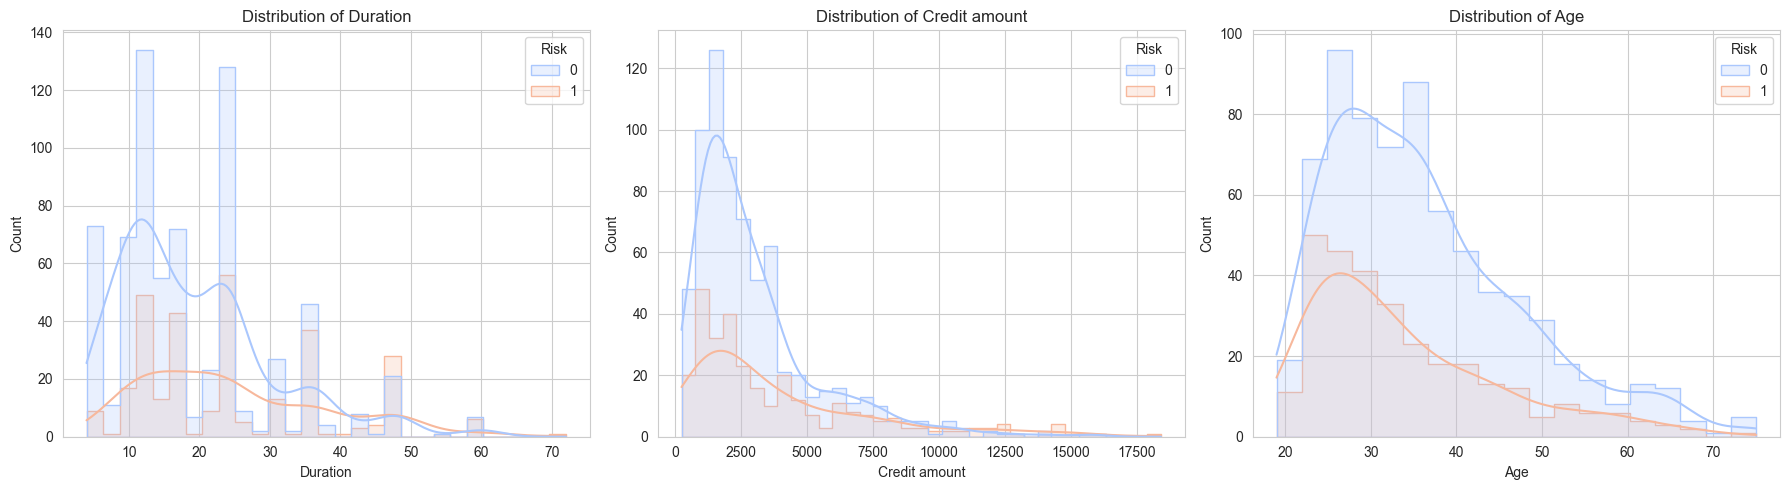


Categorical Features and Their Attributes:
         Feature  Unique Count                                                                                                 Values
             Sex             2                                                                                           female, male
             Job             4                                                                                             0, 1, 2, 3
         Housing             3                                                                                        free, own, rent
 Saving accounts             4                                                                     little, moderate, quite rich, rich
Checking account             3                                                                                 little, moderate, rich
         Purpose             8 business, car, domestic appliances, education, furniture/equipment, radio/TV, repairs, vacation/others

Sex - Value Distr

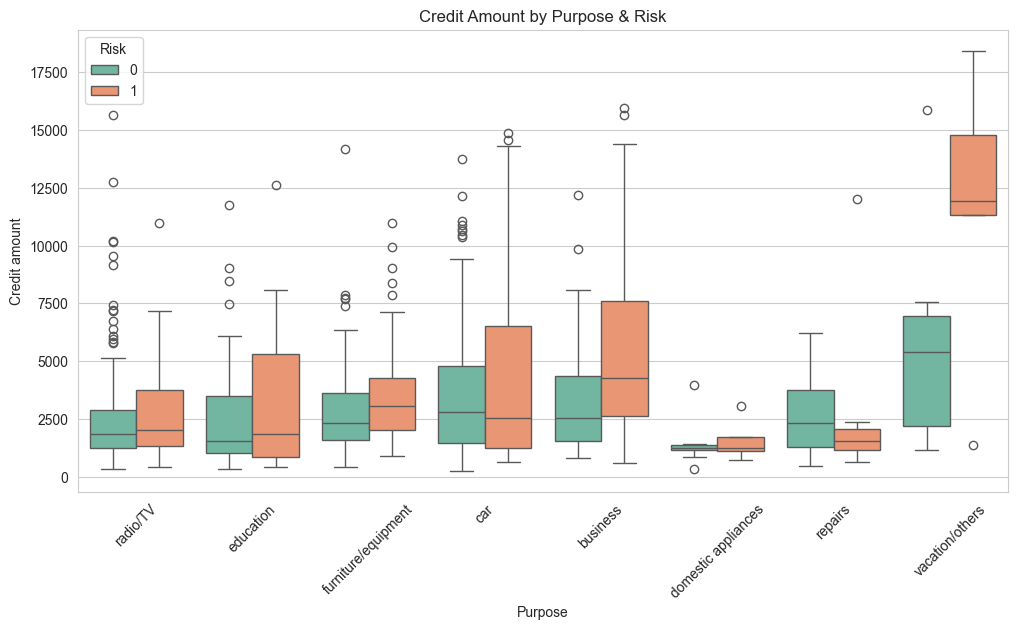

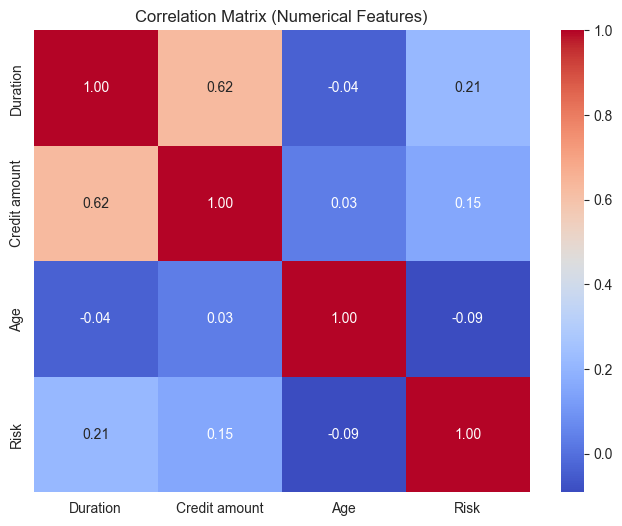

DURATION FEATURE ANALYSIS

Duration unique values (sorted):
  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 24, 26, 27, 28, 30, 33, 36, 39, 40, 42, 45, 47, 48, 54, 60, 72]


In [4]:
# 2. Exploratory Data Analysis (EDA)
print("Starting EDA Analysis")

plt.figure(figsize=(6, 4))
sns.countplot(x='Risk', data=df, palette='viridis')
plt.title('Target Distribution: Good (0) vs Bad (1) Credit Risk')
plt.xlabel('Credit Risk')
plt.ylabel('Count')
plt.show()

num_features = ['Duration', 'Credit amount', 'Age']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_features):
    sns.histplot(data=df, x=col, hue='Risk', kde=True, element="step", ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2.2b Categorical Features Attributes
print("\nCategorical Features and Their Attributes:")
cat_features = [col for col in df.columns if col not in num_features and col != 'Risk']

# Create a summary table
cat_summary = []
for col in cat_features:
    unique_count = df[col].nunique()
    unique_vals = sorted([v for v in df[col].unique() if pd.notna(v)])
    cat_summary.append({
        'Feature': col,
        'Unique Count': unique_count,
        'Values': ', '.join(map(str, unique_vals[:10]))  # Show first 10 values
    })

cat_summary_df = pd.DataFrame(cat_summary)
print(cat_summary_df.to_string(index=False))

# Detailed value counts for each categorical feature
for col in cat_features:
    print(f"\n{col} - Value Distribution:")
    value_counts = df[col].value_counts(dropna=False)
    for val, count in value_counts.items():
        print(f"  {val}: {count}")


# 2.3 Categorical Variables Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Purpose', y='Credit amount', hue='Risk', data=df, palette='Set2')
plt.title('Credit Amount by Purpose & Risk')
plt.xticks(rotation=45)
plt.show()

# 2.4 Correlation Matrix
plt.figure(figsize=(8, 6))
corr = df[num_features + ['Risk']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

# 2.5 Duration Analysis
print("DURATION FEATURE ANALYSIS")
print(f"\nDuration unique values (sorted):")
duration_uniques = sorted(df['Duration'].unique())
print(f"  {duration_uniques}")

In [5]:
# 3. Feature Engineering

# Label Encoding for Categorical Features
target_col = "Risk"
exclude_cols = [target_col, "Credit amount", "Age", "Duration"]
categorical_cols = [c for c in df.columns if c not in exclude_cols]

# Initialize label encoders dictionary
label_encoders = {}

# Encode target variable
label_encoders['Risk'] = LabelEncoder()
df[target_col] = label_encoders['Risk'].fit_transform(df[target_col])

# Encode categorical features
df_encoded = df.copy()

# Label encode categorical features
for col in categorical_cols:
    
    # label encoding
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Scaling (only numerical features)
scaler = MinMaxScaler()
scale_cols = ["Credit amount", "Age", "Duration"]
df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])

# Data Split
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

print("Feature engineering completed!")
print(f"Encoded features shape: {df_encoded.shape}")
print(f"Label encoders created for: {list(label_encoders.keys())}")
print(f"Scaled columns: {scale_cols}")

Feature engineering completed!
Encoded features shape: (1000, 10)
Label encoders created for: ['Risk', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Scaled columns: ['Credit amount', 'Age', 'Duration']


In [6]:
# 4. Model Training Preparation & Data Splitting
print("Step 2. Performing Data Splitting (60% Train, 20% Val, 20% Test)")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"   Train set shape: {X_train.shape}")
print(f"   Val   set shape: {X_val.shape}")
print(f"   Test  set shape: {X_test.shape}")

count_0 = (y_train == 0).sum()
count_1 = (y_train == 1).sum()
weight_ratio = count_0 / count_1
print(f"   Auto-calculated scale_pos_weight: {weight_ratio:.2f}")
print(f"   Label encoders available: {list(label_encoders.keys())}")


Step 2. Performing Data Splitting (60% Train, 20% Val, 20% Test)
   Train set shape: (600, 9)
   Val   set shape: (200, 9)
   Test  set shape: (200, 9)
   Auto-calculated scale_pos_weight: 2.33
   Label encoders available: ['Risk', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


In [7]:
def evaluate_and_visualize_model(model, X_test, y_test, model_name, X_train, y_train, X_val, y_val, results=None, cm_color='Blues'):
    """
    Comprehensive model evaluation and visualization function
    
    Parameters:
    - model: trained model
    - X_test, y_test: test data
    - model_name: name of the model (str)
    - X_train, y_train, X_val, y_val: training and validation data for learning curves
    - results: evals_result() dict from model (optional, for learning curves)
    - cm_color: color for confusion matrix heatmap
    
    Returns:
    - Dictionary containing all metrics and arrays
    """
    
    print(f"\nEvaluating {model_name}")
    
    # ===== Learning Curves (if available) =====
    if results is not None:
        print(f"\n{model_name} Learning Curves")
        
        train_loss = None
        val_loss = None
        train_error = None
        val_error = None
        
        if 'logloss' in results.get('validation_0', {}):
            train_loss = results['validation_0']['logloss']
            val_loss = results['validation_1']['logloss']
            train_error = results['validation_0']['error']
            val_error = results['validation_1']['error']
        # Check if results is in CatBoost/LightGBM format (with 'loss')
        elif 'loss' in results.get('validation_0', {}):
            train_loss = results['validation_0']['loss']
            # Handle case where validation_1 might not exist
            if 'validation_1' in results:
                val_loss = results['validation_1']['loss']
            else:
                val_loss = None
        
        if train_loss is not None and val_loss is not None:
            epochs = len(train_loss)
            if epochs > 0:
                x_axis = range(0, epochs)
                
                if train_error is not None and val_error is not None:
                    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
                    ax[0].plot(x_axis, train_loss, label='Train')
                    ax[0].plot(x_axis, val_loss, label='Validation')
                    ax[0].legend()
                    ax[0].set_title(f'{model_name} Learning Curve: Log Loss')
                    ax[0].set_ylabel('Log Loss')
                    ax[0].set_xlabel('Epochs')
                    
                    # Classification Error Curve
                    ax[1].plot(x_axis, train_error, label='Train')
                    ax[1].plot(x_axis, val_error, label='Validation')
                    ax[1].legend()
                    ax[1].plot(x_axis, train_error, label='Train')
                    ax[1].plot(x_axis, val_error, label='Validation')
                    ax[1].legend()
                    ax[1].set_title(f'{model_name} Learning Curve: Classification Error')
                    ax[1].set_ylabel('Error Rate')
                    ax[1].set_xlabel('Epochs')
                    
                    # Accuracy Curve
                    train_acc = [1 - x for x in train_error]
                    val_acc = [1 - x for x in val_error]
                    
                    ax[2].plot(x_axis, train_acc, label='Train')
                    ax[2].plot(x_axis, val_acc, label='Validation')
                    ax[2].legend()
                    ax[2].set_title(f'{model_name} Learning Curve: Accuracy')
                    ax[2].set_ylabel('Accuracy')
                    ax[2].set_xlabel('Epochs')
                else:
                    # CatBoost/LightGBM format: 1 subplot (only loss)
                    fig, ax = plt.subplots(figsize=(12, 7))
                    
                    ax.plot(x_axis, train_loss, label='Train', linewidth=2.5, marker='o', markersize=4, alpha=0.8)
                    ax.plot(x_axis, val_loss, label='Validation', linewidth=2.5, marker='s', markersize=4, alpha=0.8)
                    ax.legend(fontsize=12, loc='best')
                    ax.set_title(f'{model_name} Learning Curve: Loss', fontsize=14, fontweight='bold')
                    ax.set_ylabel('Loss', fontsize=12)
                    ax.set_xlabel('Epochs', fontsize=12)
                    ax.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
    
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    f1_scores = [f1_score(y_test, (y_prob >= thr).astype(int)) for thr in thresholds]
    best_idx = np.argmax(f1_scores)
    best_thr = thresholds[best_idx]
    
    print(f"\nBest decision threshold by F1: {best_thr:.3f}, F1 = {f1_scores[best_idx]:.4f}")
    # ===== Calculate Metrics =====
    y_pred = (y_prob >= best_thr).astype(int)
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"\nModel Evaluation Results ({model_name}, threshold={best_thr:.3f}):")
    print(f"Accuracy : {acc:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("-" * 30)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # ===== Confusion Matrix =====
    plt.figure(figsize=(6, 5))
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cm_color, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # ===== ROC Curve =====
    plt.figure(figsize=(6, 5))
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # ===== Return Dictionary =====
    return {
        'y_prob': y_prob,
        'y_pred': y_pred,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'best_thr': best_thr,
        'acc': acc,
        'auc': auc,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'cm': cm
    }


In [8]:
print("\nStep 3. Starting GridSearchCV..")

param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 1.0],
    'scale_pos_weight': [weight_ratio * 0.8, weight_ratio, weight_ratio * 1.2],
}

xgb = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    use_label_encoder=False, 
    random_state=42
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n Grid Search completed!")
print(f"   Best params: {grid_search.best_params_}")
print(f"   Best validation F1 score: {grid_search.best_score_:.4f}")

# 5. Train Final Model with Early Stopping
print("\nStep 4. Training final model with early stopping")

best_params = grid_search.best_params_

xgb_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric=['logloss', 'error'], 
    early_stopping_rounds=15, 
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)




Step 3. Starting GridSearchCV..
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

 Grid Search completed!
   Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'scale_pos_weight': 2.8000000000000003}
   Best validation F1 score: 0.5898

Step 4. Training final model with early stopping


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=['logloss', 'error'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [9]:
print("\n" + "="*60)
print("CATBOOST MODEL TRAINING")
print("="*60)

from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("\nStep 1. CatBoost GridSearchCV")

catboost_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200,300],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 0.5],
}

catboost = CatBoostClassifier(
    verbose=0,
    random_state=42,
    scale_pos_weight=weight_ratio
)

grid_search_cb = GridSearchCV(
    estimator=catboost,
    param_grid=catboost_param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search_cb.fit(X_train, y_train)

print(f"\nCatBoost GridSearch completed!")
print(f"Best params: {grid_search_cb.best_params_}")
print(f"Best validation F1 score: {grid_search_cb.best_score_:.4f}")

print("\nStep 2. Training final CatBoost model with early stopping")

best_params_cb = grid_search_cb.best_params_

catboost_model = CatBoostClassifier(
    **best_params_cb,
    verbose=0,
    random_state=42,
    scale_pos_weight=weight_ratio,
    early_stopping_rounds=15
)

catboost_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
)

# Extract CatBoost evaluation history
cb_evals = catboost_model.evals_result_
cb_logloss_learn = cb_evals['learn']['Logloss']
cb_logloss_val = cb_evals['validation_1']['Logloss']
results_cb = {
    'validation_0': {'loss': cb_logloss_learn},  # Train loss
    'validation_1': {'loss': cb_logloss_val}      # Validation loss
}

print(f"CatBoost model training completed!")



CATBOOST MODEL TRAINING

Step 1. CatBoost GridSearchCV
Fitting 3 folds for each of 162 candidates, totalling 486 fits

CatBoost GridSearch completed!
Best params: {'bagging_temperature': 0, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best validation F1 score: 0.6163

Step 2. Training final CatBoost model with early stopping
CatBoost model training completed!


In [10]:
print("\n" + "="*60)
print("LIGHTGBM MODEL TRAINING")
print("="*60)

from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

print("\nStep 1. LightGBM GridSearchCV")

lightgbm_param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.5, 1.0],
}

lightgbm = LGBMClassifier(
    verbose=-1,
    random_state=42,
    scale_pos_weight=weight_ratio,
    is_unbalance=False
)

grid_search_lgb = GridSearchCV(
    estimator=lightgbm,
    param_grid=lightgbm_param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid_search_lgb.fit(X_train, y_train)

print(f"\nLightGBM GridSearch completed!")
print(f"   Best params: {grid_search_lgb.best_params_}")
print(f"   Best validation F1 score: {grid_search_lgb.best_score_:.4f}")

# Step 2: Train Final LightGBM Model
print("\nStep 2. Training final LightGBM model")

best_params_lgb = grid_search_lgb.best_params_

lgb_model = LGBMClassifier(
    **best_params_lgb,
    verbose=-1,
    random_state=42,
    scale_pos_weight=weight_ratio,
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='binary_logloss'
)

# Extract LightGBM evaluation history
lgb_evals = lgb_model.evals_result_
lgb_logloss_train = lgb_evals['training']['binary_logloss']
lgb_logloss_val = lgb_evals['valid_1']['binary_logloss']

results_lgb = {
    'validation_0': {'loss': lgb_logloss_train},
    'validation_1': {'loss': lgb_logloss_val}
}

print(f"LightGBM model training completed!")



LIGHTGBM MODEL TRAINING

Step 1. LightGBM GridSearchCV
Fitting 3 folds for each of 72 candidates, totalling 216 fits

LightGBM GridSearch completed!
   Best params: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 1.0}
   Best validation F1 score: 0.5831

Step 2. Training final LightGBM model
LightGBM model training completed!



XGBOOST MODEL EVALUATION

Evaluating XGBoost

XGBoost Learning Curves


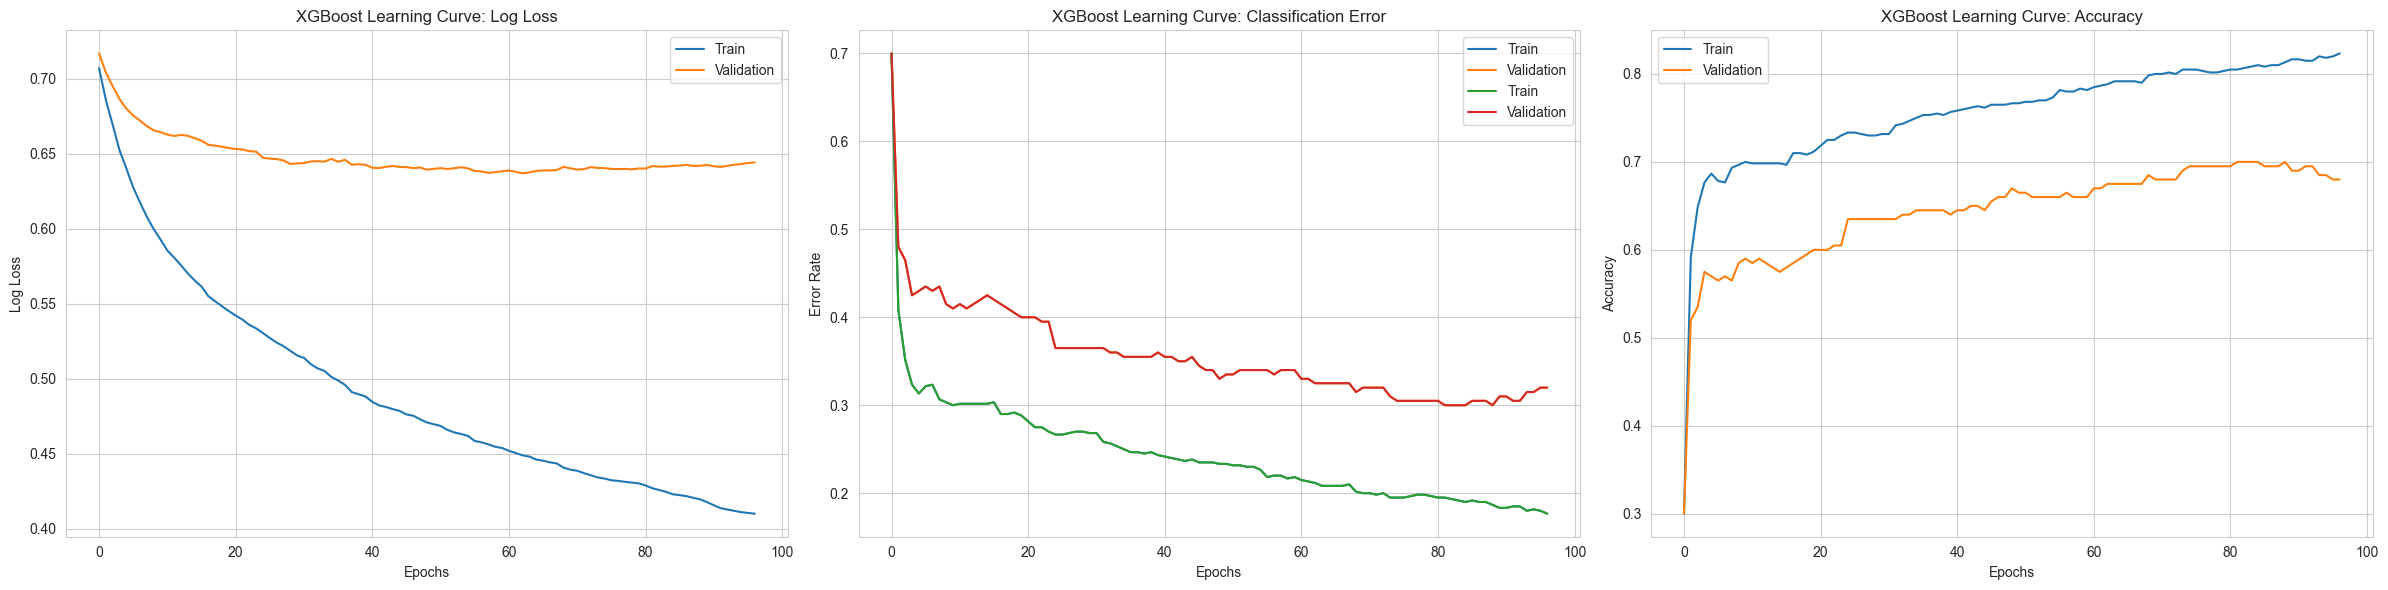


Best decision threshold by F1: 0.493, F1 = 0.6351

Model Evaluation Results (XGBoost, threshold=0.493):
Accuracy : 0.7300
ROC AUC  : 0.7832
F1 Score : 0.6351
Recall   : 0.7833
Precision: 0.5341
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       140
           1       0.53      0.78      0.64        60

    accuracy                           0.73       200
   macro avg       0.71      0.75      0.71       200
weighted avg       0.78      0.73      0.74       200



<Figure size 600x500 with 0 Axes>

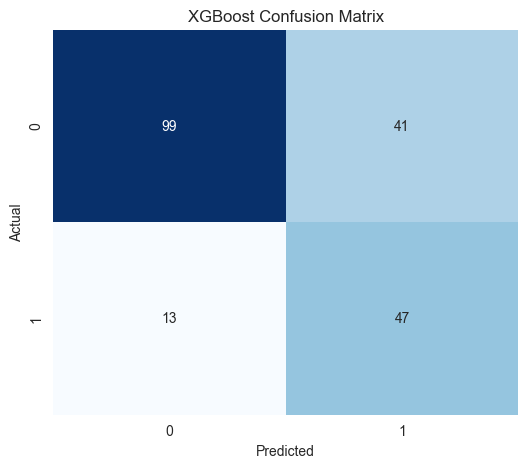

<Figure size 600x500 with 0 Axes>

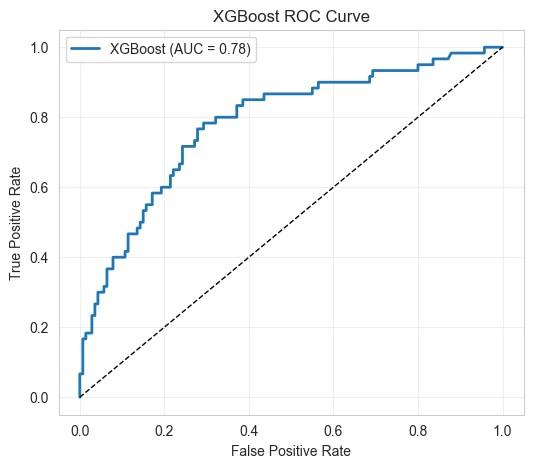

In [11]:
print("\n" + "="*60)
print("XGBOOST MODEL EVALUATION")
print("="*60)

results = xgb_model.evals_result()
xgb_results = evaluate_and_visualize_model(
    model=xgb_model,
    X_test=X_test,
    y_test=y_test,
    model_name='XGBoost',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    results=results,
    cm_color='Blues'
)

# Unpack results for backward compatibility
y_prob = xgb_results['y_prob']
y_pred = xgb_results['y_pred']
fpr = xgb_results['fpr']
tpr = xgb_results['tpr']
thresholds = xgb_results['thresholds']
best_thr = xgb_results['best_thr']
acc = xgb_results['acc']
auc = xgb_results['auc']
f1 = xgb_results['f1']
recall = xgb_results['recall']
precision = xgb_results['precision']
cm = xgb_results['cm']



CATBOOST MODEL EVALUATION

Evaluating CatBoost

CatBoost Learning Curves


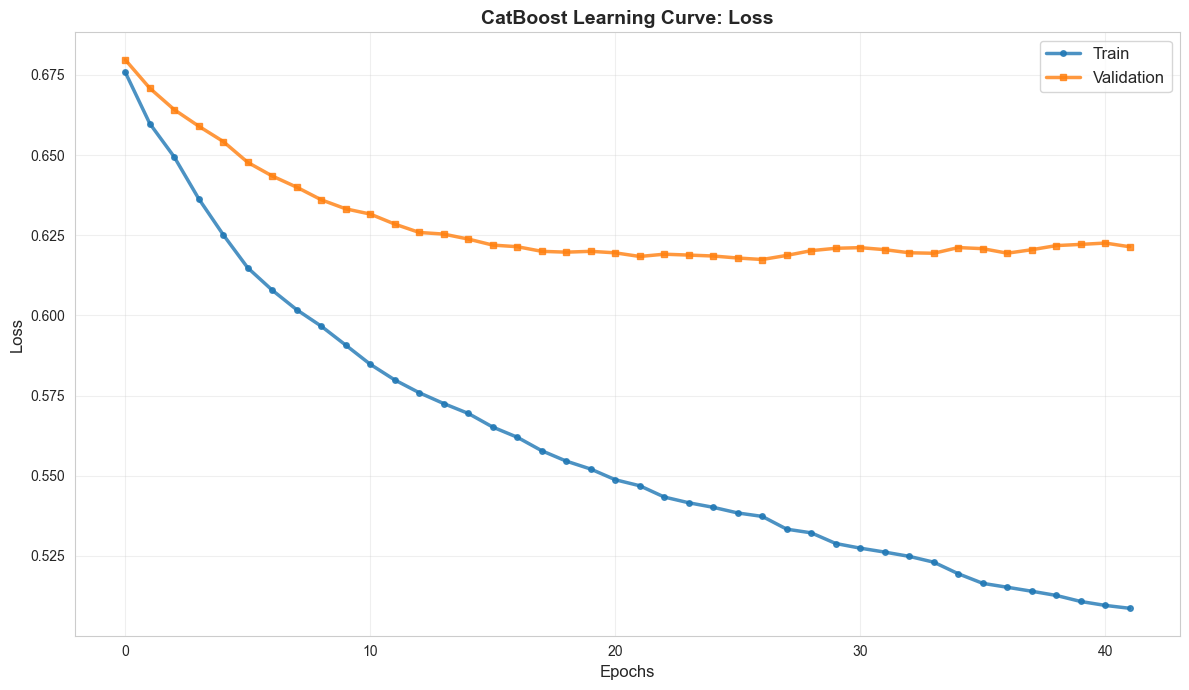


Best decision threshold by F1: 0.460, F1 = 0.6144

Model Evaluation Results (CatBoost, threshold=0.460):
Accuracy : 0.7050
ROC AUC  : 0.7842
F1 Score : 0.6144
Recall   : 0.7833
Precision: 0.5054
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       140
           1       0.51      0.78      0.61        60

    accuracy                           0.70       200
   macro avg       0.69      0.73      0.69       200
weighted avg       0.77      0.70      0.72       200



<Figure size 600x500 with 0 Axes>

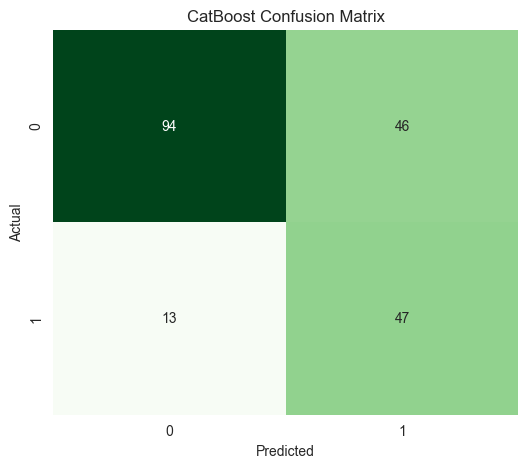

<Figure size 600x500 with 0 Axes>

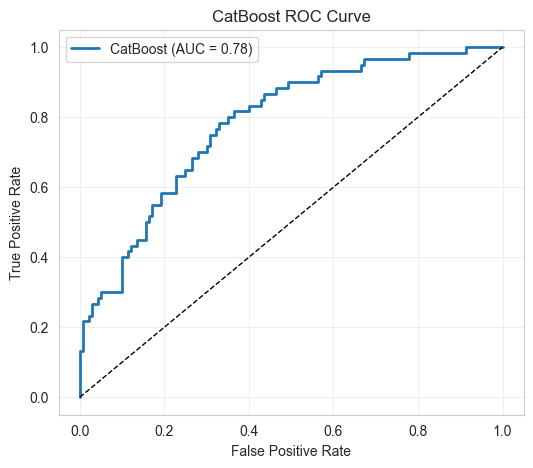

In [12]:
# Step 3: CatBoost Model Evaluation
print("\n" + "="*60)
print("CATBOOST MODEL EVALUATION")
print("="*60)

cb_results = evaluate_and_visualize_model(
    model=catboost_model,
    X_test=X_test,
    y_test=y_test,
    model_name='CatBoost',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    results=results_cb,  # Pass CatBoost evaluation history
    cm_color='Greens'
)

# Unpack results
y_prob_cb = cb_results['y_prob']
y_pred_cb = cb_results['y_pred']
fpr_cb = cb_results['fpr']
tpr_cb = cb_results['tpr']
thresholds_cb = cb_results['thresholds']
best_thr_cb = cb_results['best_thr']
acc_cb = cb_results['acc']
auc_cb = cb_results['auc']
f1_cb = cb_results['f1']
recall_cb = cb_results['recall']
precision_cb = cb_results['precision']
cm_cb = cb_results['cm']



LIGHTGBM MODEL EVALUATION

Evaluating LightGBM

LightGBM Learning Curves


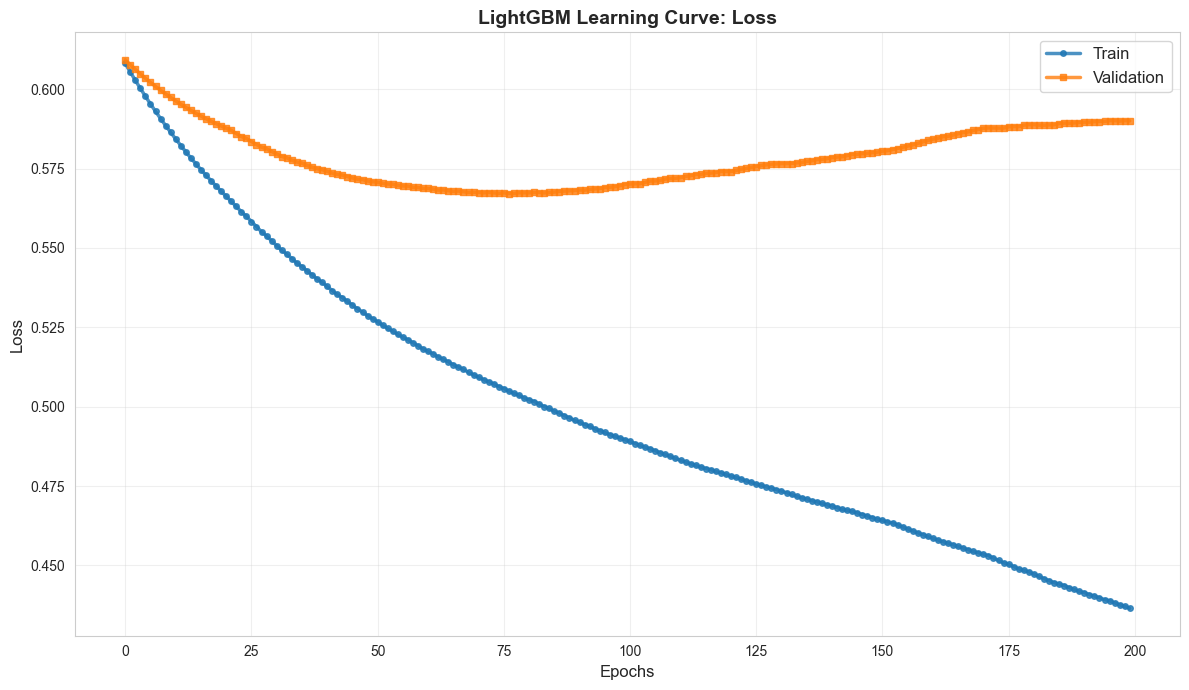


Best decision threshold by F1: 0.433, F1 = 0.6164

Model Evaluation Results (LightGBM, threshold=0.433):
Accuracy : 0.7200
ROC AUC  : 0.7780
F1 Score : 0.6164
Recall   : 0.7500
Precision: 0.5233
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       140
           1       0.52      0.75      0.62        60

    accuracy                           0.72       200
   macro avg       0.70      0.73      0.70       200
weighted avg       0.76      0.72      0.73       200



<Figure size 600x500 with 0 Axes>

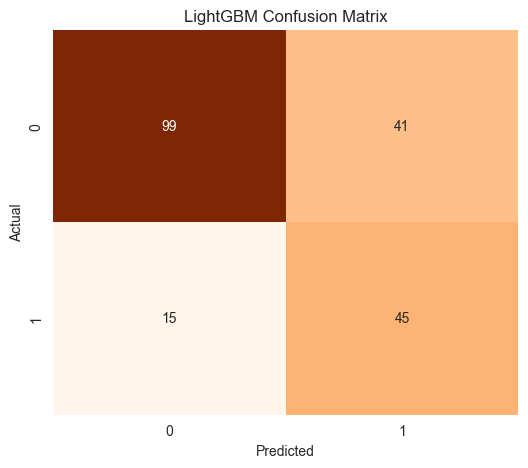

<Figure size 600x500 with 0 Axes>

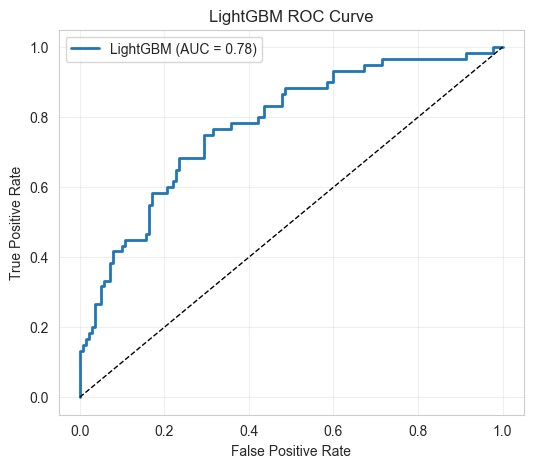

In [13]:
# Step 3: LightGBM Model Evaluation
print("\n" + "="*60)
print("LIGHTGBM MODEL EVALUATION")
print("="*60)

lgb_results = evaluate_and_visualize_model(
    model=lgb_model,
    X_test=X_test,
    y_test=y_test,
    model_name='LightGBM',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    results=results_lgb,  # Pass LightGBM evaluation history
    cm_color='Oranges'
)

# Unpack results
y_prob_lgb = lgb_results['y_prob']
y_pred_lgb = lgb_results['y_pred']
fpr_lgb = lgb_results['fpr']
tpr_lgb = lgb_results['tpr']
thresholds_lgb = lgb_results['thresholds']
best_thr_lgb = lgb_results['best_thr']
acc_lgb = lgb_results['acc']
auc_lgb = lgb_results['auc']
f1_lgb = lgb_results['f1']
recall_lgb = lgb_results['recall']
precision_lgb = lgb_results['precision']
cm_lgb = lgb_results['cm']


THREE-MODEL COMPARISON: XGBoost vs CatBoost vs LightGBM

Comprehensive Performance Comparison

----------------------------------------------------------------------
Metric          XGBoost            CatBoost           LightGBM          
----------------------------------------------------------------------
Accuracy        0.7300             0.7050             0.7200            
ROC AUC         0.7832             0.7842             0.7780            
F1 Score        0.6351             0.6144             0.6164            
Recall          0.7833             0.7833             0.7500            
Precision       0.5341             0.5054             0.5233            
----------------------------------------------------------------------


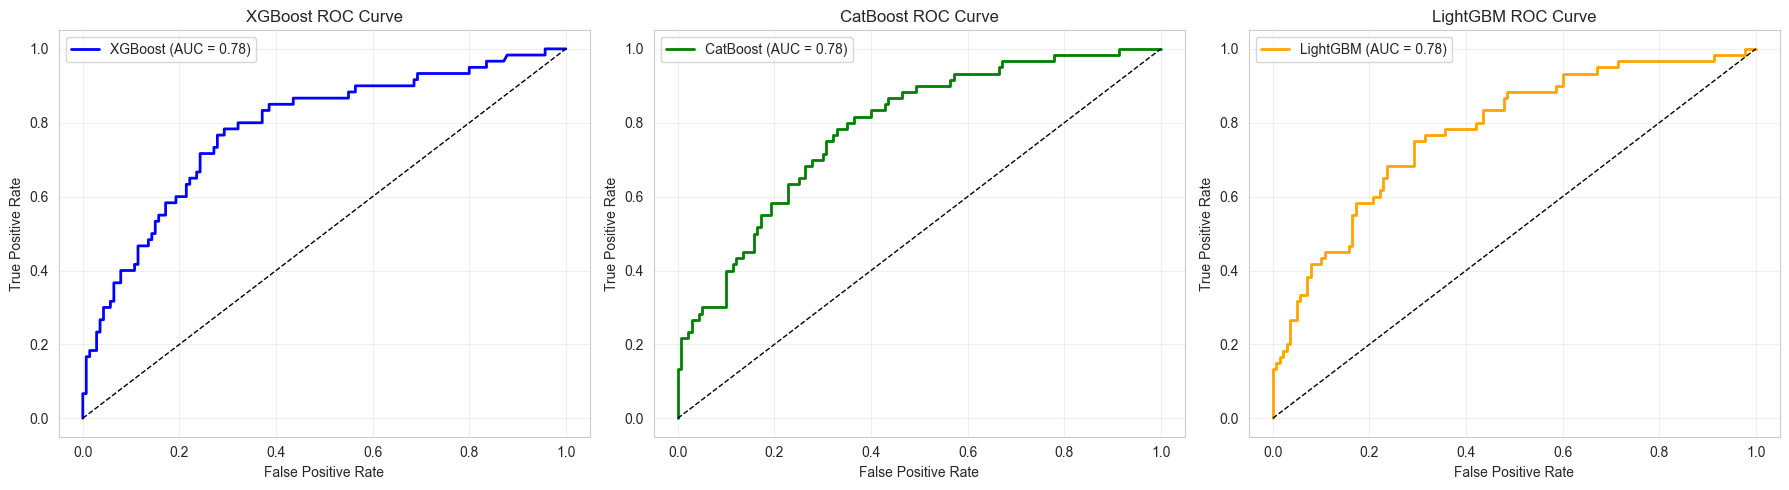

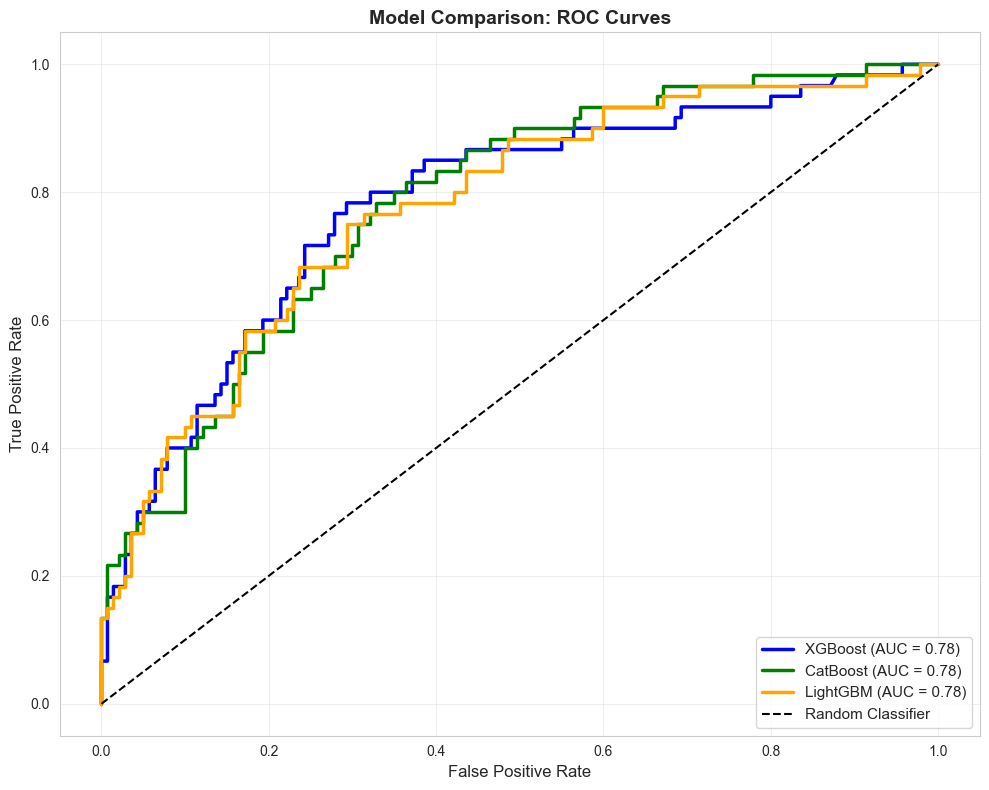

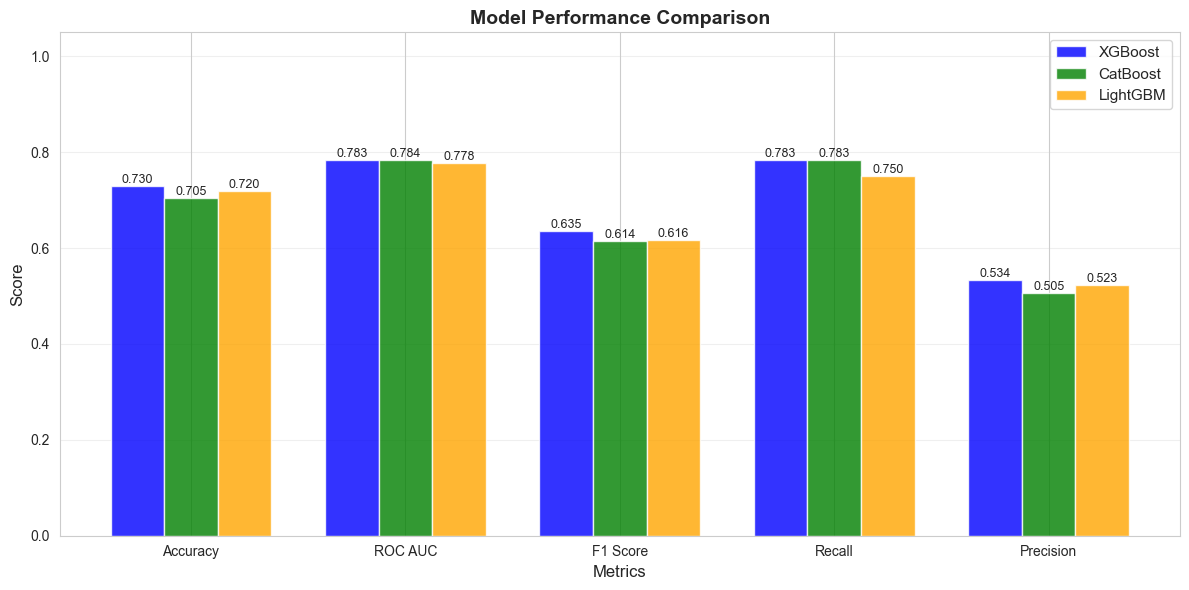


Selecting best model for XAI analysis
Selected: XGBoost (F1=0.6351)


In [14]:
print("THREE-MODEL COMPARISON: XGBoost vs CatBoost vs LightGBM")
print("="*70)

print("\nComprehensive Performance Comparison")
print("\n" + "-"*70)
print(f"{'Metric':<15} {'XGBoost':<18} {'CatBoost':<18} {'LightGBM':<18}")
print("-"*70)
print(f"{'Accuracy':<15} {acc:<18.4f} {acc_cb:<18.4f} {acc_lgb:<18.4f}")
print(f"{'ROC AUC':<15} {auc:<18.4f} {auc_cb:<18.4f} {auc_lgb:<18.4f}")
print(f"{'F1 Score':<15} {f1:<18.4f} {f1_cb:<18.4f} {f1_lgb:<18.4f}")
print(f"{'Recall':<15} {recall:<18.4f} {recall_cb:<18.4f} {recall_lgb:<18.4f}")
print(f"{'Precision':<15} {precision:<18.4f} {precision_cb:<18.4f} {precision_lgb:<18.4f}")
print("-"*70)

# Visualization: Three-model ROC curves side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# XGBoost ROC
axes[0].plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})', linewidth=2, color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('XGBoost ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CatBoost ROC
axes[1].plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})', linewidth=2, color='green')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('CatBoost ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# LightGBM ROC
axes[2].plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.2f})', linewidth=2, color='orange')
axes[2].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('LightGBM ROC Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization: Combined ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})', linewidth=2.5, color='blue')
ax.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.2f})', linewidth=2.5, color='green')
ax.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.2f})', linewidth=2.5, color='orange')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Model Comparison: ROC Curves', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Model Performance Comparison (Bar Chart)
metrics_names = ['Accuracy', 'ROC AUC', 'F1 Score', 'Recall', 'Precision']
xgb_scores = [acc, auc, f1, recall, precision]
cb_scores = [acc_cb, auc_cb, f1_cb, recall_cb, precision_cb]
lgb_scores = [acc_lgb, auc_lgb, f1_lgb, recall_lgb, precision_lgb]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_names))
width = 0.25

bars1 = ax.bar(x - width, xgb_scores, width, label='XGBoost', color='blue', alpha=0.8)
bars2 = ax.bar(x, cb_scores, width, label='CatBoost', color='green', alpha=0.8)
bars3 = ax.bar(x + width, lgb_scores, width, label='LightGBM', color='orange', alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Select best model based on F1 score
print("\nSelecting best model for XAI analysis")
scores = {
    'XGBoost': (f1, xgb_model, y_pred, y_prob),
    'CatBoost': (f1_cb, catboost_model, y_pred_cb, y_prob_cb),
    'LightGBM': (f1_lgb, lgb_model, y_pred_lgb, y_prob_lgb)
}

best_f1 = max(scores.values(), key=lambda x: x[0])[0]
best_model_name = [k for k, v in scores.items() if v[0] == best_f1][0]
best_model, y_pred_best, y_prob_best = scores[best_model_name][1:]

print(f"Selected: {best_model_name} (F1={best_f1:.4f})")



[Task 3] XAI Analysis using XGBoost model

Computing SHAP values


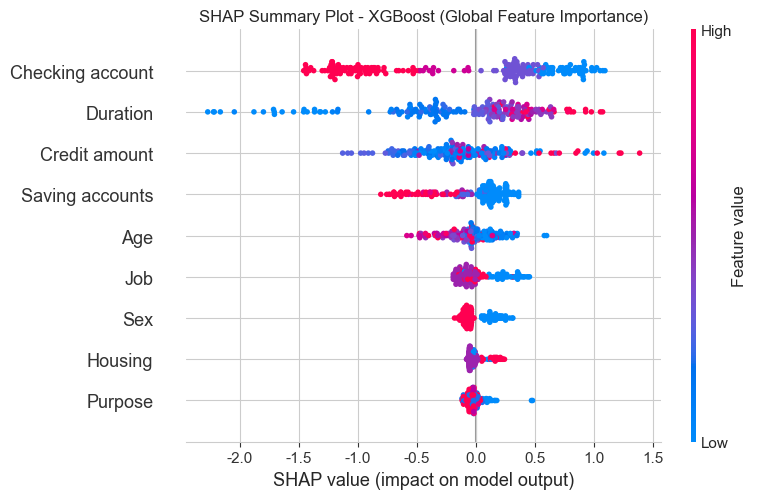

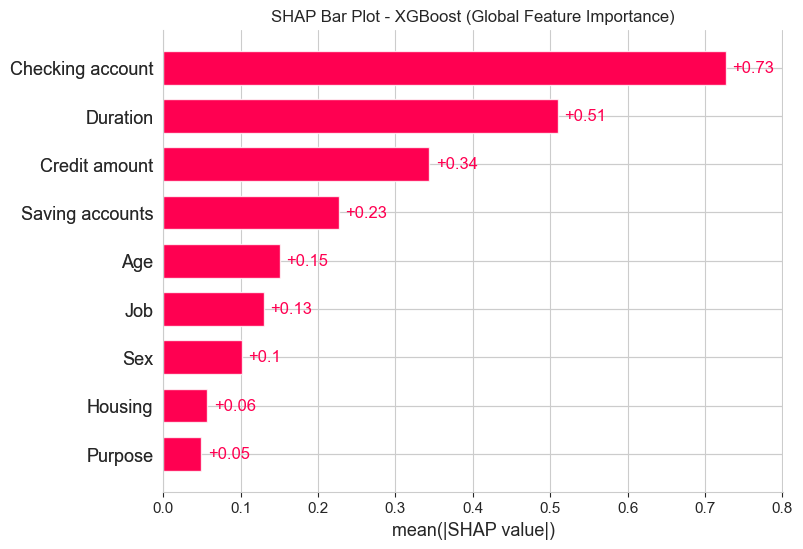

Interpretation: Heatmap shows feature importance variations across samples.


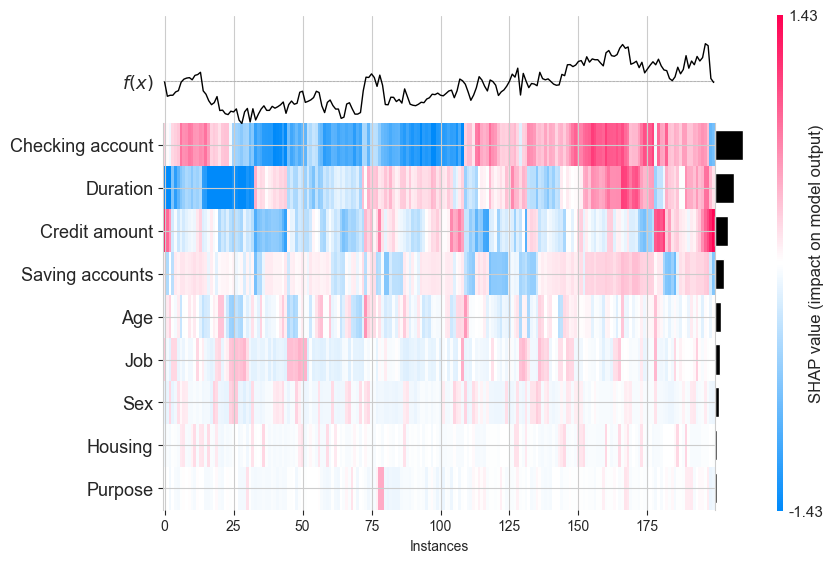

Interpretation: Dependence plot shows how 'Checking account' feature impacts model output.


<Figure size 1000x600 with 0 Axes>

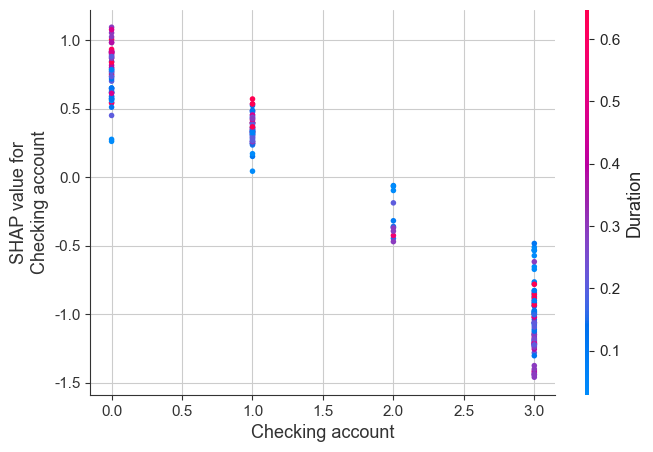

In [28]:
# 8. XAI Applications (SHAP & DiCE)
print(f"\n[Task 3] XAI Analysis using {best_model_name} model")

print("\nComputing SHAP values")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.figure(figsize=(10, 6))
plt.title(f"SHAP Summary Plot - {best_model_name} (Global Feature Importance)")
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

# Summary Plot
plt.figure(figsize=(10, 6))
plt.title(f"SHAP Bar Plot - {best_model_name} (Global Feature Importance)")
shap.plots.bar(
    shap.Explanation(
        values=shap_values,
        data=X_test,
        feature_names=X_test.columns
    ),
    show=False
)

plt.show()

# Heatmap
print("Interpretation: Heatmap shows feature importance variations across samples.")
plt.figure(figsize=(10, 6))
shap_exp = shap.Explanation(shap_values, data=X_test, feature_names=X_test.columns)
shap.plots.heatmap(shap_exp)
plt.show()

# Dependence Plot for a specific feature
print("Interpretation: Dependence plot shows how 'Checking account' feature impacts model output.")
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "Checking account",
    shap_values,
    X_test,
    show=False
)
plt.show()


Local Explanation - Sample ID: 0


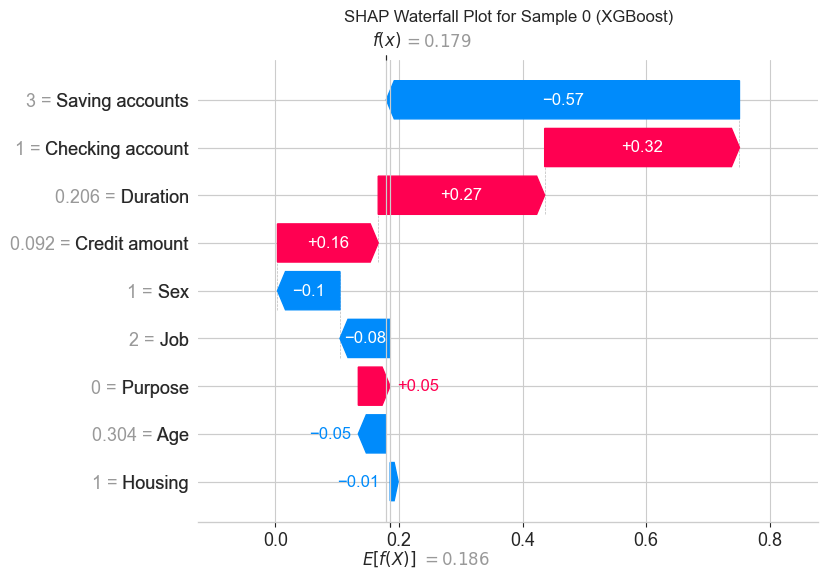

In [30]:
# Local Explanation
bad_indices = np.where(y_pred_best == 1)[0]
if len(bad_indices) > 0:
    target_idx = bad_indices[0]
    print(f"\nLocal Explanation - Sample ID: {target_idx}")
    
    plt.figure(figsize=(8, 8))
    shap_exp = shap.Explanation(values=shap_values[target_idx], 
                                base_values=explainer.expected_value, 
                                data=X_test.iloc[target_idx],
                                feature_names=X_test.columns)
    shap.plots.waterfall(shap_exp, show=False)
    plt.title(f"SHAP Waterfall Plot for Sample {target_idx} ({best_model_name})")
    plt.show()
else:
    print("No Bad Credit predictions found in test set.")



ERROR ANALYSIS: FALSE POSITIVE CASES (Type I Error)
False Positive = Model predicted Bad (1) but actually Good (0)

Found 41 false positive cases
Analyzing False Positive Sample ID: 0

False Positive Sample Details:
  Actual Class: Good (0)
  Predicted Class: Bad (1)
  Prediction Probability: 0.5447


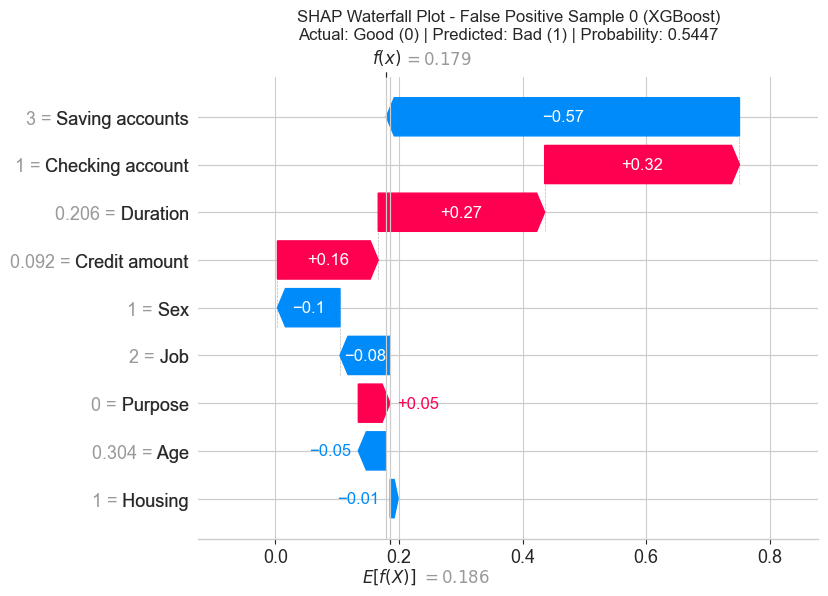

In [33]:
# Error Analysis: False Positive Case
print("\n" + "="*70)
print("ERROR ANALYSIS: FALSE POSITIVE CASES (Type I Error)")
print("="*70)
print("False Positive = Model predicted Bad (1) but actually Good (0)")

# Find false positives: y_pred == 1 and y_test == 0
fp_indices = np.where((y_pred_best == 1) & (y_test == 0))[0]

if len(fp_indices) > 0:
    print(f"\nFound {len(fp_indices)} false positive cases")
    fp_idx = fp_indices[0]
    print(f"Analyzing False Positive Sample ID: {fp_idx}")
    
    # Display the false positive sample details
    print("\nFalse Positive Sample Details:")
    print(f"  Actual Class: Good (0)")
    print(f"  Predicted Class: Bad (1)")
    print(f"  Prediction Probability: {y_prob_best[fp_idx]:.4f}")
    
    # SHAP Waterfall Plot for False Positive
    plt.figure(figsize=(10, 8))
    shap_exp_fp = shap.Explanation(
        values=shap_values[fp_idx], 
        base_values=explainer.expected_value, 
        data=X_test.iloc[fp_idx],
        feature_names=X_test.columns
    )
    shap.plots.waterfall(shap_exp_fp, show=False)
    plt.title(f"SHAP Waterfall Plot - False Positive Sample {fp_idx} ({best_model_name})\n" +
              f"Actual: Good (0) | Predicted: Bad (1) | Probability: {y_prob_best[fp_idx]:.4f}")
    plt.show()
    
else:
    print("No False Positive cases found in test set.")


In [19]:
# 8.2 DiCE (Counterfactuals)
print("\n[Task 3] Generating DiCE counterfactual explanations")
# ModelWrapper
class ModelWrapper:
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        return self.model.predict(X.apply(pd.to_numeric, errors='coerce').fillna(0))
    def predict_proba(self, X):
        return self.model.predict_proba(X.apply(pd.to_numeric, errors='coerce').fillna(0))

wrapped_model = ModelWrapper(best_model)

# Only original numerical features are available
continuous_features = ['Credit amount', 'Age', 'Duration']
continuous_features = [col for col in continuous_features if col in df_encoded.columns]

d = dice_ml.Data(
    dataframe=df_encoded, 
    continuous_features=continuous_features, 
    outcome_name='Risk'
)

m = dice_ml.Model(model=wrapped_model, backend="sklearn")
exp_dice = dice_ml.Dice(d, m, method="random")

# Only vary features that exist in the training data
features_to_vary = continuous_features

if len(bad_indices) > 0:
    query_instance = X_test.iloc[[target_idx]]
    
    print(f"Generating counterfactual explanations for sample {target_idx}")
    
    dice_result = exp_dice.generate_counterfactuals(
        query_instance, 
        total_CFs=3, 
        desired_class="opposite",
        features_to_vary=features_to_vary 
    )
    
    dice_result.visualize_as_dataframe(show_only_changes=True)
else:
    print("No Bad Credit samples found. Skipping DiCE generation.")

Generating counterfactual explanations for sample 0


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:40<00:00, 40.61s/it]

Query instance (original outcome : 1)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0.303571,1,2,1,3,1,0.091504,0.205882,0,1



Diverse Counterfactual set (new outcome: 0)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0.97756239,-,-,-,-,-,-,0.17911042999994736,-,0.0
1,-,-,-,-,-,-,0.245646553,-,-,0.0
2,-,-,-,-,-,-,0.220695585,-,-,0.0


In [20]:
# 10. Save Model Components
print("\nSaving model components")
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(catboost_model, 'catboost_model.pkl')
joblib.dump(lgb_model, 'lgb_model.pkl')
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')



Saving model components


['scaler.pkl']